In [1]:
# TF - 1.13.1, scikit-learn - 0.20.3, numpy - 1.16.2, pandas - 0.24.2, matplotlib 3.0.3

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten 
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
X = pd.read_csv('../data/csv_x.csv')
y = pd.read_csv('../data/csv_y.csv')

#### Посмотрим, что из себя представляет датасет

In [3]:
y.head(1) # Чтобы узнать, как обращаться к столбцу

,10
0,10


In [4]:
y['10'].value_counts()

7     500
2     500
5     500
4     500
10    498
9     495
3     489
6     489
1     489
8     489
Name: 10, dtype: int64

Теперь мы знаем, что у нас примерно по 500 изображения каждой цифры. А еще метка цифры 0 почему-то превратилась в 10. Исправим это.

In [5]:
y = y['10'].map(lambda x: 0 if x == 10 else x)

Представим плоское представление каждой цифры (вектор длины 400) в изначальном виде (матрицы 20х20, или картинки).

In [6]:
digit_shape = (20, 20)
digits = X.values.reshape(X.shape[0], *digit_shape)

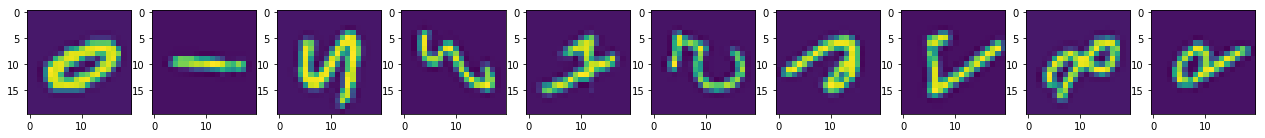

In [7]:
fig, ax = plt.subplots(1, 10, figsize=(22, 6))
digit_idx = 0
for i in range(10):
    ax[i].imshow(digits[digit_idx])
    digit_idx += 500

Хмм, очень похоже на аугментированный датасет MNIST, а именно отраженные по вертикали/горизонтали и повернутые на 90 градусов по/против часовой стрелки (ну еще расширение поджато, не будем это учитывать). Хорошо, учтем это при обучении.

In [8]:
input_shape = (20, 20, 1) # # TensorFlow использует 4 измерение как количество каналов изображения, у нас он 1 (градации серого)
X = X.values.reshape(X.shape[0], *input_shape)

In [9]:
y = utils.to_categorical(y) # Представим метки в виде One-Hot векторов

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

Воспользуемся генератором аугментированных данных. Поставим в доступные ему способы трансформации, известную нам информацию.

In [11]:
datagen = ImageDataGenerator(horizontal_flip=1, rotation_range=90)

Построим обычную CNNку. У нас многоклассовая классификация, значит softmax, в качестве активации (будет возвращать вероятности принадлежности к классу) и перекрестная энтропия в качестве функции ошибки. Качество будем смотреть по доле правильных ответов.

In [14]:
model = Sequential()

model.add(Conv2D(input_shape=input_shape, filters=32, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
model.fit(datagen.flow(X_train, y_train), epochs=30, validation_data=(X_test, y_test), verbose=1)

Epoch 1/30
140/140 [==============================] - 2s 12ms/step - loss: 1.9190 - acc: 0.3029 - val_loss: 1.1073 - val_acc: 0.6404
Epoch 2/30
140/140 [==============================] - 1s 9ms/step - loss: 1.1394 - acc: 0.6152 - val_loss: 0.7606 - val_acc: 0.7394
Epoch 3/30
140/140 [==============================] - 1s 9ms/step - loss: 0.8204 - acc: 0.7299 - val_loss: 0.5999 - val_acc: 0.8182
Epoch 4/30
140/140 [==============================] - 1s 9ms/step - loss: 0.6320 - acc: 0.8051 - val_loss: 0.4423 - val_acc: 0.8707
Epoch 5/30
140/140 [==============================] - 1s 9ms/step - loss: 0.5327 - acc: 0.8354 - val_loss: 0.3598 - val_acc: 0.8949
Epoch 6/30
140/140 [==============================] - 1s 9ms/step - loss: 0.4707 - acc: 0.8552 - val_loss: 0.3136 - val_acc: 0.9010
Epoch 7/30
140/140 [==============================] - 1s 9ms/step - loss: 0.4374 - acc: 0.8626 - val_loss: 0.3163 - val_acc: 0.9071
Epoch 8/30
140/140 [==============================] - 1s 9ms/step - loss: 0

Итак, мы видим наше качество на тесте, оценка довольно неустойчивая, так как размер тестовой выборки очень скромный. Но, ей можно верить. Имеем около __95%__.

Если не использовать в обучении аугментирование данных, итоговое качество получается под __99%__ (я проверял). Но мы перестраховались, и решили научить нейронку "смотреть на вещи шире", потеряв при этом в качестве. В зависимости от потребностей задач, можно менять подход к обучению.

Так как мы учились на аугментированных данных, можно проверить качество модели на изначальных данных (оценка может оказаться завышенной, но не сильно).

In [16]:
pred = model.predict(X)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(y, axis=1)

In [19]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_true, pred)

In [23]:
print('Процент ошибок:', np.round((1 - score) * 100, 2), '%')

Процент ошибок: 3.17 %
